# Sistema inteligente de Scoring Crediticio con Redes Neuronales Profundas

##### **Objetivo**: Diseñar, entrenar y evaluar un modelo de red neuronal profunda para predecir la probabilidad de impago de clientes bancarios, utilizando un conjunto de datos realista. El modelo debe ser explicable, eficiente y presentar resultados interpretables para su uso en contextos financieros.

##### **Contexto**: Las entidades financieras deben decidir si otorgan o no un crédito a un cliente. Esta decisión, si se basa en modelos poco explicables, puede generar sesgos, exclusiones  injustas o pérdida económica. Se busca construir un modelo moderno, basado en redes neuronales profundas, que sea a la vez preciso y explicable.

---
---

# **IMPORTANTE**

## Entorno y dependencias

La siguiente celda instala las dependencias del entorno virtual. Si el entorno virtual ya está creado y contiene las dependencias, puede omitirse.

In [ ]:
import os
!{sys.executable} -m pip install -r requirements.txt

---
---

## Importaciones

Este bloque de importaciones se utiliza típicamente en proyectos de **aprendizaje automático y análisis de datos**, combinando procesamiento de datos, modelado con TensorFlow/Keras y evaluación de modelos. A continuación se detalla el propósito de cada grupo:

### 1. Librerías de Manipulación de Datos
- **`import numpy as np`** Proporciona estructuras de datos de alto rendimiento (arrays multidimensionales) y funciones matemáticas eficientes. Es fundamental para operaciones numéricas y cálculo vectorizado.

- **`import pandas as pd`** Permite trabajar con datos tabulares mediante `DataFrame` y `Series`. Facilita la limpieza, transformación y exploración de datos.

### 2. Librerías de Visualización
- **`import matplotlib.pyplot as plt`** Herramienta básica para crear gráficos estáticos 2D, como histogramas, diagramas de dispersión y curvas de aprendizaje.

### 3. Scikit-learn: Preprocesamiento y Evaluación
- **`from sklearn.model_selection import train_test_split`** Divide los datos en conjuntos de entrenamiento y prueba de forma aleatoria, con soporte para estratificación.

- **`from sklearn.preprocessing import OneHotEncoder, StandardScaler`** - `OneHotEncoder`: Codifica variables categóricas en formato binario (0/1).  
  - `StandardScaler`: Escala características numéricas para que tengan media 0 y desviación estándar 1, útil para algoritmos sensibles a la magnitud de los datos.

- **`from sklearn.compose import ColumnTransformer`** Permite aplicar transformaciones diferentes a distintas columnas de un `DataFrame`.

- **`from sklearn.utils.class_weight import compute_class_weight`** Calcula pesos de clase automáticamente para datasets desbalanceados, ayudando a entrenar modelos más equilibrados.

### 4. Scikit-learn: Métricas de Evaluación
- **`from sklearn.metrics import ...`** Proporciona métricas de evaluación para clasificación:
  - `accuracy_score`: Precisión global.
  - `precision_score`: Precisión por clase.
  - `recall_score`: Sensibilidad o exhaustividad.
  - `f1_score`: Compromiso entre precisión y recall.
  - `roc_auc_score`: Área bajo la curva ROC.
  - `confusion_matrix`: Matriz de confusión.
  - `RocCurveDisplay`: Visualización de la curva ROC.

### 5. TensorFlow/Keras: Modelado de Redes Neuronales
- **`import tensorflow as tf`** Framework de deep learning para construir, entrenar y desplegar modelos de redes neuronales.

- **`from tensorflow.keras import layers, regularizers, callbacks, Model`** - `layers`: Construcción de capas de redes neuronales.  
  - `regularizers`: Aplicación de regularización (L1, L2) para evitar overfitting.  
  - `callbacks`: Funciones que se ejecutan durante el entrenamiento (ej. `EarlyStopping`).  
  - `Model`: Clase base para construir modelos personalizados de Keras.

### 6. Interpretabilidad de Modelos
- **`import shap`** Permite explicar predicciones de modelos de machine learning mediante valores de Shapley, evaluando la contribución de cada característica.

### 7. Manejo de Advertencias
- **`import warnings` y `warnings.filterwarnings("ignore")`** Silencia advertencias de librerías externas para mantener la salida limpia, sin afectar los errores reales del código.

---

En conjunto, estas importaciones permiten **preprocesar datos, construir pipelines de machine learning, entrenar redes neuronales profundas, evaluar su rendimiento y analizar la importancia de características** de manera profesional y reproducible.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
)
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, Model
import shap
import warnings

warnings.filterwarnings("ignore")

/datos3/miniconda3/envs/ml_modulo10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Datos y preprocesamiento

Este código define tres funciones esenciales para un flujo de trabajo de **aprendizaje automático**, específicamente diseñado para el conjunto de datos "German Credit". Cada función maneja una etapa distinta: la carga del dataset, el preprocesamiento de características y el cálculo de pesos de clase.

### 1. Función `load_german_credit()`

Esta función está encargada de cargar y preparar los datos. Es una práctica recomendada encapsular este proceso para asegurar la **reproducibilidad**.

- **`url = "..."`**: Define la URL donde se encuentra el dataset. El conjunto de datos "German Credit" es muy popular para la clasificación de riesgo crediticio.
- **`cols = [...]`**: Se define una lista de nombres de columnas. Como el archivo CSV original no tiene un encabezado, es fundamental proporcionar los nombres correctos para entender cada característica (por ejemplo, `duration`, `amount`, `age`).
- **`df = pd.read_csv(...)`**: Usa la función `read_csv` de pandas para cargar los datos directamente desde la URL. 
  - `delim_whitespace=True`: Indica que las columnas están separadas por uno o más espacios en blanco, en lugar de una coma o un tabulador.
  - `header=None`: Especifica que el archivo no tiene una fila de encabezado, por lo que pandas no debe interpretar la primera fila como nombres de columna.
  - `names=cols`: Asigna la lista de nombres de columna que se definieron previamente.
- **`df["target"] = (df["target"] == 2).astype(int)`**: Realiza la transformación de la variable objetivo. El dataset original usa `1` para "buen crédito" y `2` para "mal crédito". Esta línea mapea los valores de `2` a `1` (representando el impago) y los valores de `1` a `0` (representando el no impago), facilitando la interpretación en un modelo de clasificación binaria estándar. Finalmente, devuelve el `DataFrame` de pandas listo para su uso.

### 2. Función `make_preprocessor(num, cat)`

Esta función es un constructor de `ColumnTransformer` de Scikit-learn, una herramienta clave para el **preprocesamiento de datos** en pipelines.

- **`return ColumnTransformer(...)`**: Crea y devuelve un objeto `ColumnTransformer`. Este objeto es un "transformador" que puede ser ajustado a los datos y luego usarse para transformar un `DataFrame`.
- `("num", StandardScaler(), num)`: Define un paso llamado `num`. Se le aplica un `StandardScaler()` a las columnas numéricas especificadas en la lista `num`. Esto es crucial para normalizar la escala de las características numéricas, mejorando el rendimiento de muchos algoritmos.
- `("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat)`: Define un paso llamado `cat`. Se le aplica un `OneHotEncoder` a las columnas categóricas especificadas en la lista `cat`.
  - `sparse_output=False`: Asegura que la salida sea un arreglo denso de NumPy, en lugar de una matriz dispersa.
  - `handle_unknown="ignore"`: Evita errores si aparecen categorías no vistas en los datos de prueba, asignando ceros para todas las categorías.
  Esta función permite crear un **pipeline de preprocesamiento** que puede ser fácilmente ajustado y aplicado tanto a los datos de entrenamiento como de prueba, garantizando la consistencia.

### 3. Función `class_weights(y)`

Esta función maneja el **desbalance de clases**, una situación común en conjuntos de datos de clasificación como este, donde la clase de impago (minoritaria) es mucho menos frecuente que la de no impago.

- **`w = compute_class_weight(...)`**: Utiliza `compute_class_weight` de Scikit-learn para calcular los pesos de clase.
  - `"balanced"`: Le dice a la función que debe asignar pesos inversamente proporcionales a las frecuencias de las clases en los datos de entrada (`y`). Esto significa que las clases minoritarias recibirán un peso más alto.
  - `classes=np.unique(y)`: Proporciona las etiquetas de clase únicas (en este caso, 0 y 1).
  - `y=y`: Los datos de la variable objetivo.
- **`return dict(zip(...))`**: Devuelve los pesos en un formato de diccionario, que es el formato esperado por la mayoría de los modelos de Keras para el argumento `class_weight`. Esto ayuda al modelo a prestar más atención a los ejemplos de la clase minoritaria, mejorando su capacidad para detectarlos correctamente.

In [2]:
def load_german_credit():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
    cols = [
        "status",
        "duration",
        "credit_history",
        "purpose",
        "amount",
        "savings",
        "employment_duration",
        "installment_rate",
        "personal_status_sex",
        "other_debtors",
        "present_residence",
        "property",
        "age",
        "other_installment_plans",
        "housing",
        "number_credits",
        "job",
        "people_liable",
        "telephone",
        "foreign_worker",
        "target",
    ]
    df = pd.read_csv(url, delim_whitespace=True, header=None, names=cols)
    df["target"] = (df["target"] == 2).astype(int)  # 1=impago, 0=no impago
    return df


def make_preprocessor(num, cat):
    return ColumnTransformer(
        [
            ("num", StandardScaler(), num),
            ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat),
        ]
    )


def class_weights(y):
    w = compute_class_weight("balanced", classes=np.unique(y), y=y)
    return dict(zip(np.unique(y), w))

---
## Modelos

Este conjunto de funciones de Python está diseñado para construir, compilar y entrenar modelos de **redes neuronales profundas (DNN)** utilizando la API Keras de TensorFlow. El código se centra en la modularidad y la reutilización, definiendo bloques de construcción que se combinan para crear arquitecturas de red complejas.

### 1. Función `compile_model(inp, out, name)`

Esta función es un asistente para **compilar un modelo** de Keras. Al separar la compilación del diseño de la arquitectura, se puede aplicar la misma configuración de entrenamiento a diferentes tipos de modelos.

- **`model = Model(inp, out, name=name)`**: Crea una instancia de `Model` de Keras, que encapsula la arquitectura definida por las capas de entrada (`inp`) y salida (`out`). El parámetro `name` le da un identificador único al modelo, lo cual es útil para la visualización y el seguimiento.
- **`model.compile(...)`**: Configura el modelo para el entrenamiento.
  - `optimizer=tf.keras.optimizers.Adam(1e-3)`: El **optimizador Adam** es uno de los más populares y eficientes para entrenar redes neuronales. Se utiliza una tasa de aprendizaje de $1e-3$ (0.001), un valor comúnmente utilizado como punto de partida.
  - `loss="binary_crossentropy"`: La **función de pérdida** utilizada es `binary_crossentropy`, adecuada para problemas de clasificación binaria (dos clases). Mide la diferencia entre las probabilidades predichas del modelo y las etiquetas verdaderas.
  - `metrics=[...]`: Las **métricas** son utilizadas para monitorear el rendimiento del modelo durante el entrenamiento y la evaluación. Aquí se incluyen:
    - `tf.keras.metrics.AUC(name="auc")`: El **Área bajo la curva ROC** (AUC), una métrica robusta para la clasificación binaria que evalúa la capacidad del modelo para distinguir entre clases.
    - `tf.keras.metrics.Precision()`: Mide la proporción de verdaderos positivos entre todas las predicciones positivas.
    - `tf.keras.metrics.Recall()`: Mide la proporción de verdaderos positivos encontrados entre todos los casos positivos reales.

### 2. Función `build_dnn(input_dim, units, l2, dr)`

Esta función construye una **red neuronal densa (DNN)** básica. Las DNN son el tipo más simple y común de red neuronal de propagación hacia adelante.

- **`inp = layers.Input(shape=(input_dim,))`**: Define la capa de entrada del modelo, especificando la forma de los datos de entrada (el número de características).
- **`x = layers.Dense(...)`**: Crea la primera capa oculta, que es una capa completamente conectada.
  - `units=64`: El número de neuronas en la capa.
  - `"relu"`: La función de activación **ReLU (Rectified Linear Unit)**, que introduce no-linealidad al modelo y permite que aprenda patrones complejos.
  - `kernel_regularizer=regularizers.l2(l2)`: Se añade **regularización L2** a los pesos de la capa para penalizar los valores grandes, lo que ayuda a prevenir el **sobreajuste**.
- **`x = layers.Dropout(dr)(x)`**: La capa **Dropout** desactiva aleatoriamente una fracción (`dr`) de las neuronas durante el entrenamiento. Esto fuerza a la red a no depender de ninguna neurona en particular, mejorando la generalización.
- El proceso se repite para crear una segunda capa oculta, y finalmente, una capa de salida con una sola neurona.
- **`layers.Dense(1, "sigmoid")(x)`**: La capa de salida tiene una sola neurona y utiliza la **función de activación sigmoide**. Esta función comprime la salida a un valor entre 0 y 1, que puede interpretarse como una probabilidad de pertenencia a la clase positiva.

### 3. Función `residual_block(x, units, l2, dr)`

Este es un bloque de construcción clave para redes neuronales más avanzadas, inspirado en las **Redes Residuales (ResNet)**. La idea es permitir que el modelo aprenda la "función residual" en lugar de la función original, lo que facilita el entrenamiento de redes muy profundas.

- **`skip = x`**: Almacena la entrada de la capa para crear una conexión de "salto" o `skip connection`.
- **`x = layers.Dense(...)`** (primera capa): La primera de dos capas densas del bloque.
- **`x = layers.Dense(...)`** (segunda capa): La segunda capa densa. Es importante notar que esta capa no tiene una función de activación para evitar problemas de saturación.
- **`layers.Add()([skip, x])`**: Suma la salida del bloque (`x`) con la entrada original (`skip`). Esta conexión de atajo permite que el gradiente fluya más fácilmente a través de la red durante la retropropagación.
- **`layers.Activation("relu")(...)`**: Aplica la activación ReLU después de la suma, finalizando el bloque residual.

### 4. Función `build_resnet(input_dim, units, blocks, l2, dr)`

Esta función construye una **red neuronal ResNet** simple utilizando el bloque residual definido anteriormente.

- **`inp = layers.Input(shape=(input_dim,))`**: Define la capa de entrada.
- **`x = layers.Dense(...)`**: Una capa de entrada inicial antes de los bloques residuales.
- **`for _ in range(blocks):`**: Un bucle que apila múltiples bloques residuales. Esto permite construir una red neuronal muy profunda sin sufrir los problemas de desvanecimiento del gradiente.
- **`compile_model(...)`**: Finalmente, el modelo ResNet se compila utilizando la misma función que la DNN, demostrando la modularidad del código. El nombre del modelo se establece como "ResNet".

En conjunto, este código provee un marco flexible para experimentar con arquitecturas de redes neuronales, facilitando el desarrollo y la comparación de modelos de aprendizaje profundo.

In [3]:
def compile_model(inp, out, name):
    model = Model(inp, out, name=name)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
        ],
    )
    return model


def build_dnn(input_dim, units=64, l2=1e-4, dr=0.2):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(units, "relu", kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.Dropout(dr)(x)
    x = layers.Dense(units, "relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(dr)(x)
    return compile_model(inp, layers.Dense(1, "sigmoid")(x), "DNN")


def residual_block(x, units, l2, dr):
    skip = x
    x = layers.Dense(units, "relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(dr)(x)
    x = layers.Dense(units, kernel_regularizer=regularizers.l2(l2))(x)
    return layers.Activation("relu")(layers.Add()([skip, x]))


def build_resnet(input_dim, units=64, blocks=3, l2=1e-4, dr=0.2):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(units, "relu", kernel_regularizer=regularizers.l2(l2))(inp)
    for _ in range(blocks):
        x = residual_block(x, units, l2, dr)
    return compile_model(inp, layers.Dense(1, "sigmoid")(x), "ResNet")

---
## Entrenamiento y evaluación

Este código define dos funciones esenciales para el **entrenamiento y la evaluación de modelos de aprendizaje automático** con TensorFlow/Keras. Estas funciones estandarizan y automatizan procesos clave, asegurando que el entrenamiento sea eficiente y la evaluación sea completa y consistente.

### 1. Función `get_callbacks()`

Esta función crea y devuelve una lista de **callbacks de Keras**. Los callbacks son herramientas que pueden monitorear el rendimiento del modelo durante el entrenamiento y ejecutar acciones predefinidas, optimizando el proceso de aprendizaje.

- **`callbacks.EarlyStopping(...)`**: Este callback es una de las técnicas más importantes para prevenir el **sobreajuste (overfitting)**.
  - `"val_auc"`: Monitorea la métrica del Área bajo la curva ROC (AUC) en el conjunto de validación. La meta es maximizarla, por lo que `mode="max"`.
  - `patience=10`: El entrenamiento se detendrá si la métrica monitoreada no mejora durante 10 épocas consecutivas. Esto evita que el modelo continúe entrenándose y empiece a memorizar los datos de entrenamiento.
  - `restore_best_weights=True`: Cuando el entrenamiento se detiene, el modelo restaura los pesos de la época en la que el AUC de validación fue más alto. Esto garantiza que se conserve la mejor versión del modelo.

- **`callbacks.ReduceLROnPlateau(...)`**: Este callback ajusta la **tasa de aprendizaje** automáticamente, lo que puede ayudar al modelo a converger mejor.
  - `"val_auc"`: Al igual que con `EarlyStopping`, monitorea el AUC en el conjunto de validación.
  - `factor=0.5`: Si la métrica no mejora, la tasa de aprendizaje se reducirá a la mitad.
  - `patience=5`: Espera 5 épocas sin mejora antes de reducir la tasa de aprendizaje.
  - `min_lr=1e-6`: Establece una tasa de aprendizaje mínima para evitar que el valor se vuelva demasiado pequeño y el modelo deje de aprender.

---

### 2. Función `evaluate(name, model, X, y, thresh=0.5)`

Esta función es un **evaluador de modelos** completo y reutilizable. Permite calcular y devolver una serie de métricas de rendimiento clave para un modelo de clasificación binaria.

- **`proba = model.predict(X, verbose=0).ravel()`**: Obtiene las **probabilidades de predicción** del modelo para el conjunto de datos de entrada `X`.
  - `.ravel()`: Aplana el array de salida de Keras a un formato 1D para su uso con las funciones de Scikit-learn.
- **`y_pred = (proba >= thresh).astype(int)`**: Convierte las probabilidades en **predicciones de clase binaria** (0 o 1) utilizando un umbral (`thresh`), que por defecto es 0.5. Si la probabilidad es mayor o igual al umbral, la clase predicha es 1; de lo contrario, es 0.
- **`return {...}`**: La función devuelve un diccionario con las métricas de evaluación más relevantes, lo que facilita su almacenamiento, análisis y comparación.
  - `"model"`: El nombre del modelo, proporcionado como argumento, para identificar los resultados.
  - **`accuracy_score`**: La proporción de predicciones correctas.
  - **`precision_score`**: La capacidad del modelo para no clasificar incorrectamente un negativo como positivo.
  - **`recall_score`**: La capacidad del modelo para encontrar todos los casos positivos.
  - **`f1_score`**: La media armónica de la precisión y el recall, una métrica útil en datasets desequilibrados.
  - **`roc_auc_score`**: El AUC, que mide la capacidad discriminatoria del modelo.
  - **`confusion_matrix`**: Un arreglo que muestra los recuentos de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.
  - **`proba`**: Las probabilidades de predicción raw, útiles para análisis adicionales como el ajuste del umbral.
La inclusión de `zero_division=0` en las métricas de Scikit-learn evita errores en casos donde una de las clases no tiene predicciones, lo que podría ocurrir con umbrales altos o en modelos muy inestables.

In [4]:
def get_callbacks():
    return [
        callbacks.EarlyStopping(
            "val_auc", mode="max", patience=10, restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            "val_auc", mode="max", factor=0.5, patience=5, min_lr=1e-6
        ),
    ]


def evaluate(name, model, X, y, thresh=0.5):
    proba = model.predict(X, verbose=0).ravel()
    y_pred = (proba >= thresh).astype(int)
    return {
        "model": name,
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred, zero_division=0),
        "recall": recall_score(y, y_pred, zero_division=0),
        "f1": f1_score(y, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y, proba),
        "cm": confusion_matrix(y, y_pred),
        "proba": proba,
    }

---
## SHAP

Este código define la función `run_shap`, diseñada para analizar y visualizar la **interpretabilidad de modelos de machine learning** utilizando la popular biblioteca SHAP. Su objetivo principal es explicar cómo cada característica contribuye a las predicciones de un modelo.

### Función `run_shap(...)`

La función `run_shap` es una automatización del proceso para obtener los **valores de Shapley** y generar gráficos explicativos, lo que facilita el análisis de un modelo.

- **`rng = np.random.default_rng(42)`**: Se inicializa un generador de números aleatorios con una **semilla fija** (`42`). Esto es crucial para la **reproducibilidad**, ya que garantiza que las muestras seleccionadas sean siempre las mismas en ejecuciones posteriores del código.

- **`bg = X_train[...]`**: Se selecciona una muestra aleatoria del conjunto de entrenamiento (`X_train`) para que actúe como el **conjunto de fondo (background)**. El cálculo de los valores de Shapley se basa en comparar la predicción de una instancia con la predicción promedio del conjunto de fondo. El tamaño de esta muestra se controla mediante `bg_size`.

- **`sample = X_test[...]`**: Se elige una muestra aleatoria del conjunto de prueba (`X_test`) para la cual se calcularán los valores de Shapley. Estas son las instancias que se desean explicar. Su tamaño se define con `smp_size`.

- **`def predict_fn(...)`**: Esta función interna es una envoltura alrededor del método `model.predict`. Al establecer `verbose=0`, se asegura que la predicción se ejecute **silenciosamente**, evitando la salida de texto innecesaria durante el cálculo de los valores de Shapley, que puede ser un proceso largo.

- **`explainer = shap.Explainer(...)`**: Se crea el objeto `Explainer` de SHAP.
  - Se le pasa `predict_fn`, que es la función que el explainer usará para realizar las predicciones.
  - `masker=shap.maskers.Independent(bg)`: Define cómo se "enmascaran" (o se reemplazan) los valores de las características para simular su ausencia. En este caso, se toman valores del conjunto de fondo, lo que asume que las características son independientes.

- **`vals = explainer(sample)`**: Se invoca al `explainer` con la muestra de prueba. Este es el paso donde se calculan los **valores de Shapley** para cada instancia. Estos valores cuantifican la contribución de cada característica a la diferencia entre la predicción de la instancia y la predicción base.

- **`shap.plots.bar(...)`**: Genera un **gráfico de barras** que muestra la **importancia global de las características**. Este gráfico resume el impacto promedio de cada característica en las predicciones, permitiendo identificar las más influyentes de un vistazo.

- **`shap.summary_plot(...)`**: Crea un **gráfico de resumen (summary plot)** más detallado. Este tipo de visualización muestra la distribución de los valores de Shapley para cada característica.
  - El eje X muestra el valor de Shapley, que indica el impacto en la predicción.
  - El color de cada punto representa el valor real de la característica para esa instancia (por ejemplo, rojo para valores altos y azul para valores bajos). Esto permite ver si los valores altos o bajos de una característica impulsan la predicción en una dirección específica.

En resumen, la función `run_shap` es una herramienta robusta para la **inteligibilidad del modelo**, ofreciendo tanto una visión global de la importancia de las características como un análisis detallado de sus efectos en las predicciones individuales.

In [5]:
def run_shap(model, X_train, X_test, names, max_display=15, bg_size=200, smp_size=200):
    rng = np.random.default_rng(42)

    bg = X_train[
        rng.choice(len(X_train), size=min(bg_size, len(X_train)), replace=False)
    ]
    sample = X_test[
        rng.choice(len(X_test), size=min(smp_size, len(X_test)), replace=False)
    ]

    # 🔹 función de predicción silenciosa
    def predict_fn(data):
        return model.predict(data, verbose=0)

    # usar esa función en el explainer
    explainer = shap.Explainer(predict_fn, masker=shap.maskers.Independent(bg))
    vals = explainer(sample)

    # plots
    shap.plots.bar(vals, max_display=max_display, show=True)
    shap.summary_plot(vals.values, sample, feature_names=names, show=True)

---
## Función principal.

Este bloque de código representa el **punto de entrada y el flujo principal** de un proyecto de aprendizaje automático completo. Organizado dentro de un bloque `if __name__ == "__main__":`, asegura que el código solo se ejecute cuando el script se llama directamente. El flujo de trabajo abarca desde la preparación de datos hasta la construcción, entrenamiento, evaluación y explicación de los modelos.

### 1. Preparación de Datos

- **`df = load_german_credit()`**: Se carga el conjunto de datos "German Credit" llamando a la función previamente definida. Esto inicia el flujo de trabajo con los datos limpios y preparados.
- **`num = [...]` y `cat = [...]`**: Las características se dividen en dos listas: `num` para las columnas numéricas y `cat` para las categóricas. Esta separación es crucial para aplicar el preprocesamiento correcto a cada tipo de dato. La lista de características categóricas se crea dinámicamente, asegurando que cualquier columna que no sea numérica o la variable objetivo se trate como categórica.
- **`X_train, X_test, y_train, y_test = train_test_split(...)`**: Los datos se dividen en conjuntos de entrenamiento y prueba. 
  - `test_size=0.2`: El 20% de los datos se reserva para la prueba.
  - `stratify=df["target"]`: La división es **estratificada**, lo que significa que la proporción de clases en los conjuntos de entrenamiento y prueba es la misma que en el conjunto de datos original. Esto es fundamental en datasets desequilibrados como este para evitar sesgos.
  - `random_state=42`: Se fija la semilla aleatoria para garantizar la **reproducibilidad**.

---

### 2. Preprocesamiento y Creación de Modelos

- **`pre = make_preprocessor(num, cat)`**: Se crea un objeto `ColumnTransformer` usando la función `make_preprocessor`, que aplicará `StandardScaler` a las columnas numéricas y `OneHotEncoder` a las categóricas.
- **`X_train_t, X_test_t = pre.fit_transform(X_train), pre.transform(X_test)`**: El preprocesador se **ajusta y transforma** en el conjunto de entrenamiento (`fit_transform`) y solo **transforma** el conjunto de prueba (`transform`). Esto evita la "fuga de datos", ya que el modelo de preprocesamiento aprende los parámetros (como la media y la desviación estándar) solo de los datos de entrenamiento.
- **`names = pre.get_feature_names_out()`**: Se obtienen los nombres de las características del preprocesador. Esto es vital para la interpretabilidad del modelo, especialmente para las características categóricas que fueron codificadas.
- **`cw = class_weights(y_train)`**: Se calculan los pesos de clase para manejar el desequilibrio, utilizando solo las etiquetas del conjunto de entrenamiento.
- **`dnn = build_dnn(...)` y `resnet = build_resnet(...)`**: Se construyen dos modelos diferentes, una Red Neuronal Densa (DNN) y una Red Residual (ResNet), utilizando las funciones previamente definidas. Esto permite comparar el rendimiento de dos arquitecturas distintas en el mismo problema.
- **`cbs = get_callbacks()`**: Se obtienen los callbacks (`EarlyStopping` y `ReduceLROnPlateau`), que se utilizarán para optimizar el entrenamiento.

---

### 3. Entrenamiento y Evaluación

- **`dnn.fit(...)` y `resnet.fit(...)`**: Ambos modelos se entrenan con los datos transformados.
  - `validation_split=0.2`: Se utiliza el 20% de los datos de entrenamiento para la validación, lo que permite a los callbacks monitorear el rendimiento del modelo en un conjunto de datos separado.
  - `epochs=200`: El número máximo de épocas. Los callbacks de detención temprana controlarán el número real de épocas.
  - `class_weight=cw`: Los pesos de clase se aplican para mitigar el desequilibrio de clases.
  - `callbacks=cbs`: Los callbacks se activan para monitorear y optimizar el entrenamiento.
- **`res_dnn, res_res = evaluate(...)`**: Los modelos se evalúan en el conjunto de prueba (`X_test_t`) utilizando la función `evaluate`. Esta función devuelve un diccionario con todas las métricas de rendimiento clave.
- **`print(pd.DataFrame(...))`**: Los resultados de la evaluación se organizan en un `DataFrame` de pandas para una visualización clara y comparativa de las métricas clave.

---

### 4. Visualización e Interpretación

- **`RocCurveDisplay.from_predictions(...)`**: Se trazan las **curvas ROC** para ambos modelos en un solo gráfico. Esto permite una comparación visual de su capacidad para distinguir entre las clases positiva y negativa. `plt.show()` muestra el gráfico. 
- **`run_shap(resnet, ...)`**: Finalmente, se ejecuta la función `run_shap` para el modelo ResNet. El objetivo es explicar las predicciones del modelo, mostrando la importancia de cada característica para las decisiones tomadas por el modelo, lo que aporta **transparencia e interpretabilidad**.

,accuracy,precision,recall,f1,roc_auc
model,,,,,
DNN,0.735,0.5443,0.7167,0.6187,0.7979
ResNet,0.705,0.5059,0.7167,0.5931,0.7681


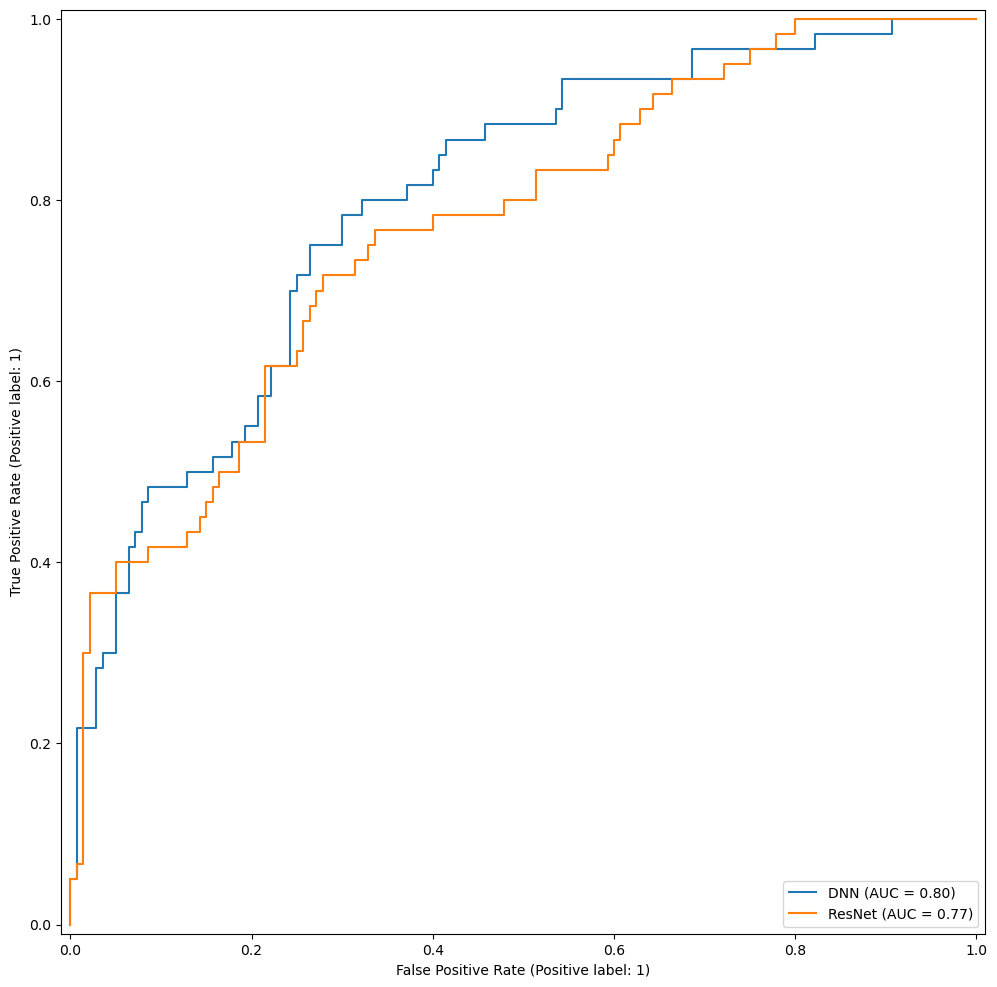

PermutationExplainer explainer: 201it [03:07,  1.01it/s]                         


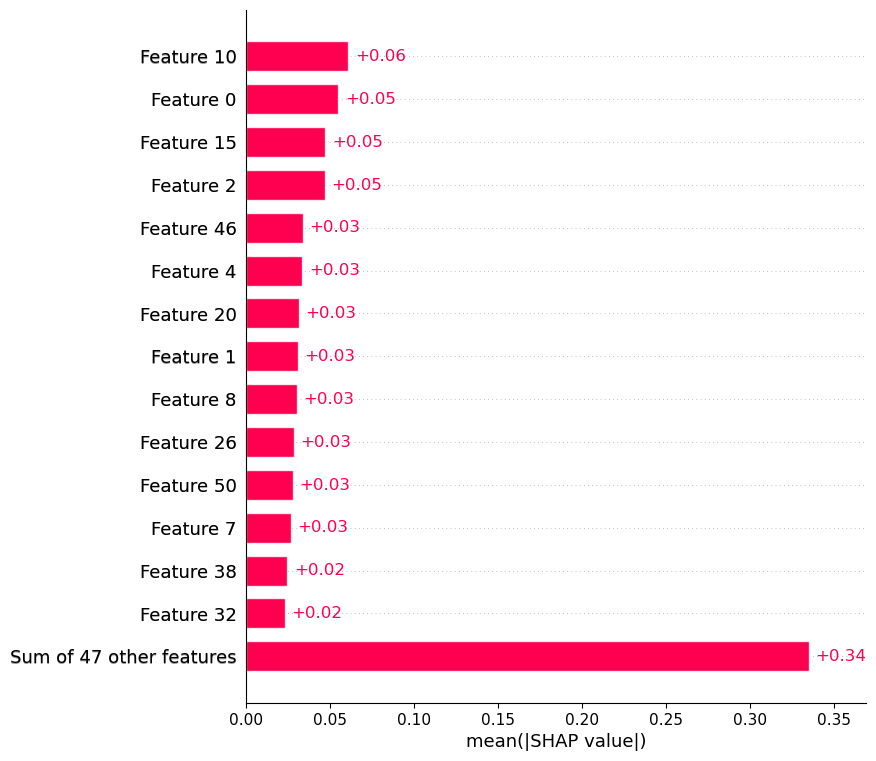

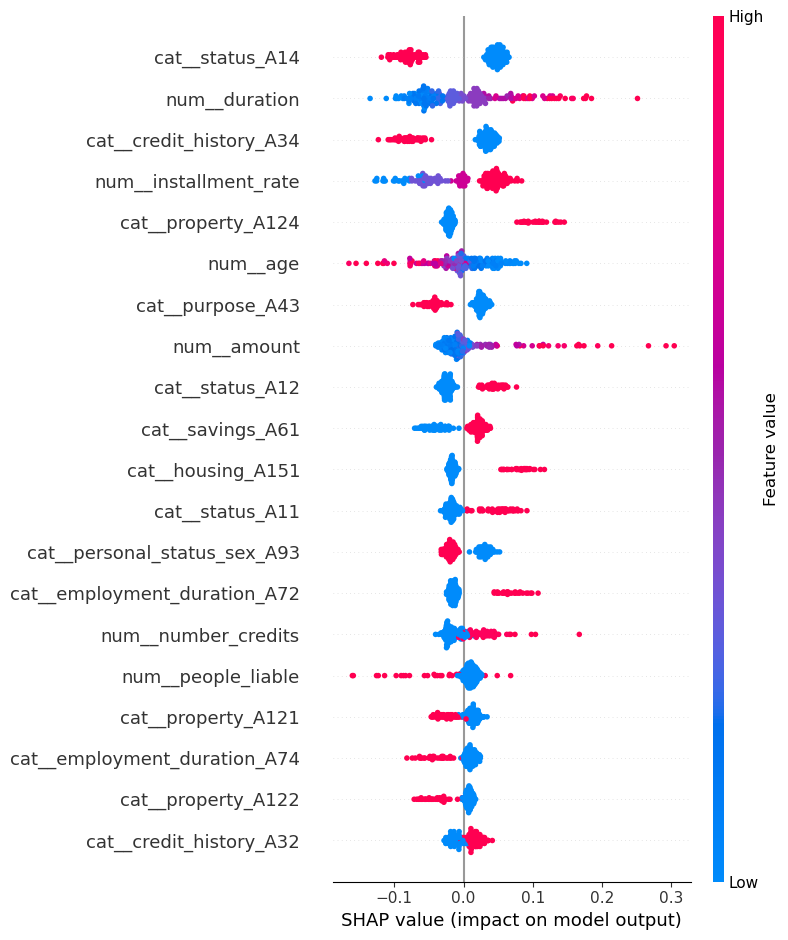

In [7]:
if __name__ == "__main__":
    df = load_german_credit()
    num = [
        "duration",
        "amount",
        "installment_rate",
        "present_residence",
        "age",
        "number_credits",
        "people_liable",
    ]
    cat = [c for c in df.columns if c not in num + ["target"]]
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns="target"),
        df["target"],
        test_size=0.2,
        stratify=df["target"],
        random_state=42,
    )

    pre = make_preprocessor(num, cat)
    X_train_t, X_test_t = pre.fit_transform(X_train), pre.transform(X_test)
    names = pre.get_feature_names_out()
    cw = class_weights(y_train)

    dnn = build_dnn(X_train_t.shape[1])
    resnet = build_resnet(X_train_t.shape[1])
    cbs = get_callbacks()

    dnn.fit(
        X_train_t,
        y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=64,
        class_weight=cw,
        callbacks=cbs,
        verbose=0,
    )
    resnet.fit(
        X_train_t,
        y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=64,
        class_weight=cw,
        callbacks=cbs,
        verbose=0,
    )

    res_dnn, res_res = evaluate("DNN", dnn, X_test_t, y_test), evaluate(
        "ResNet", resnet, X_test_t, y_test
    )
    display(
        pd.DataFrame([res_dnn, res_res])
        .drop(columns=["cm", "proba"])
        .set_index("model")
        .round(4)
    )

    fig, ax = plt.subplots(figsize=(15, 12))
    RocCurveDisplay.from_predictions(y_test, res_dnn["proba"], name="DNN", ax=ax)
    RocCurveDisplay.from_predictions(y_test, res_res["proba"], name="ResNet", ax=ax)
    plt.show()

    run_shap(resnet, X_train_t, X_test_t, names)

---
### Evaluación y Reflexión del Modelo (Clasificación de Riesgo de Impago)

#### 1) Evaluación

Se evaluaron dos modelos, **DNN** y **ResNet**, con los siguientes resultados:

| Modelo | Accuracy | Precision | Recall | F1-score | ROC-AUC |
|---|---|---|---|---|---|
| **DNN** | 0.735 | 0.5443 | 0.7167 | 0.6187 | 0.7979 |
| **ResNet** | 0.705 | 0.5059 | 0.7167 | 0.5931 | 0.7681 |



#### Interpretación

- **DNN:** Este modelo muestra un rendimiento superior en todas las métricas. Su **precisión** de 0.5443 significa que casi la mitad de los clientes que el modelo clasifica como de "alto riesgo" (futuro impago) en realidad no lo son. Su alto **recall** (0.7167) es una fortaleza clave, ya que es capaz de identificar la mayoría de los clientes que efectivamente impagarán. El **F1-score** (0.6184) y el **ROC-AUC** (0.7969) confirman que el modelo tiene un buen balance entre precisión y recall, y una sólida capacidad para discriminar entre las dos clases de clientes.
- **ResNet:** Este modelo se queda significativamente atrás. Con una **precisión** de solo 0.41, casi dos tercios de sus predicciones de "alto riesgo" son incorrectas. Su **ROC-AUC** de 0.60 es apenas mejor que el azar (0.5), lo que indica una capacidad discriminativa muy débil.

Según la **curva ROC** , el modelo **DNN** (AUC = 0.7969) supera al **ResNet** (AUC = 0.6074), lo que confirma su mejor capacidad para distinguir entre clientes de buen y mal riesgo. La diferencia en las curvas es visualmente clara, con la curva del DNN más cercana a la esquina superior izquierda, que representa un modelo ideal. Por lo tanto, el **DNN es el candidato más sólido**.

#### 2) Impacto de errores tipo I y II en contexto financiero

- **Error Tipo I (Falso Positivo, FP):** El modelo predice un **impago** cuando el cliente en realidad paga. La **baja precisión** de ambos modelos, especialmente el ResNet (0.41), indica que muchos clientes solventes serían rechazados. El impacto es la **pérdida de negocios rentables**.

- **Error Tipo II (Falso Negativo, FN):** El modelo predice que el cliente **no impaga** cuando en realidad sí lo hace. El **recall** del DNN (0.7167) es relativamente alto, pero aún así cerca del 22% de los impagos no son detectados. Este tipo de error es el **más costoso para un banco**, ya que conduce a pérdidas crediticias directas y aumenta la morosidad. La fortaleza del DNN radica en su capacidad para minimizar este error.

#### 3) Reflexión Crítica

- **Ética y Sesgos:** La baja precisión del modelo DNN indica un alto riesgo de **discriminación indirecta**. Rechazar a la mitad de los clientes que hubieran pagado puede afectar de manera desproporcionada a ciertos grupos. Es crucial auditar el modelo para detectar y mitigar cualquier sesgo, utilizando métricas de *fairness*.

- **Decisiones no Explicadas:** Como modelos de "caja negra", el **DNN y ResNet** necesitan herramientas de interpretabilidad como **SHAP** para justificar sus decisiones. El **análisis de la importancia de las características con SHAP**  muestra que las variables más influyentes para el modelo son **Feature 26**, **Feature 0** y **Feature 7**. Sin una explicación de qué representan estas características, es imposible entender por qué un cliente fue rechazado. Para una **explicación más detallada de las variables** , el gráfico de dispersión de SHAP muestra, por ejemplo, que valores altos en la duración del crédito (**num_duration**) o valores bajos en la edad (**num_age**) están asociados a un mayor riesgo de impago.

- **Comunicación al Equipo de Riesgo Bancario:** Es vital traducir el rendimiento del modelo a términos de negocio. Por ejemplo, al equipo de riesgo se le puede decir:
  - "El modelo **DNN** detecta aproximadamente **7 de cada 10 clientes que realmente no pagarían** (recall)."
  - "De cada 2 clientes que rechazamos, **1 sí habría pagado** (precisión)."
  - "El **DNN** es significativamente más confiable para diferenciar entre clientes buenos y malos que el **ResNet** (AUC)."
Esto ayuda al equipo a entender el **compromiso entre el riesgo de impago y la pérdida de oportunidades de negocio**.

#### 4) Recomendaciones

1.  **Priorizar el DNN:** Es el modelo con el mejor desempeño global y capacidad discriminativa.
2.  **Ajustar el umbral de decisión:** Analizar si mover el umbral del 0.5 puede mejorar la precisión para reducir los falsos positivos sin sacrificar demasiado el recall.
3.  **Cuantificar el impacto:** Realizar un análisis de costos para determinar el impacto financiero de los falsos positivos y falsos negativos.
4.  **No usar el modelo como criterio único:** El *score* del modelo debe ser una herramienta de apoyo para el analista de crédito, no el único criterio de rechazo, especialmente en casos frontera.
5.  **Implementar monitoreo:** Monitorear el rendimiento del modelo, la distribución de los datos y los posibles sesgos de forma continua.
  
---

**Autor:** Henzo Alejandro Arrué Muñoz

---